In [1]:
import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
from svgd import SVGD
import stein
import kernels

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Variance estimators

In [2]:
def var_exp(gram):
    """
    Estimator for $Var_Y(E_X[h(X, Y)])$, where h is a kernel function.
    For background, see this technical report: https://arxiv.org/pdf/1906.02104.pdf
    
    Args
        gram: Gram matrix $G_{ij} = h(x_i, x_j)$. Has shape (n, n)
        
    """
    if gram.shape[0] != gram.shape[1] or gram.ndim != 2:
        raise ValueError(f"Gram matrix must have shape (n, n). Instead received shape {gram.shape}.")
        
    n = gram.shape[0]
    diagonal_indices = [list(range(n))]*2
    gramzero = index_update(gram, diagonal_indices, 0)
    return (np.linalg.norm(np.dot(gramzero, np.ones(n)))**2 - np.linalg.norm(gramzero)**2) / (n * (n-1) * (n-2))


def var_hxy(gram):
    """
    Estimator for $Var_{XY}(h(X, Y))$, where h is a symmetric function.
    For background, see this technical report: https://arxiv.org/pdf/1906.02104.pdf
    
    Args
        gram: Gram matrix $G_{ij} = h(x_i, x_j)$. Has shape (n, n)
        
    """
    if gram.shape[0] != gram.shape[1] or gram.ndim != 2:
        raise ValueError(f"Gram matrix must have shape (n, n). Instead received shape {gram.shape}.")
        
    n = gram.shape[0]
    diagonal_indices = [list(range(n))]*2
    gramzero = index_update(gram, diagonal_indices, 0)
    
    ones = np.ones(n)
    mean_of_square = np.linalg.norm(gramzero)**2 / (n * (n-1))
    mean_squared = (np.dot(np.dot(ones, gramzero), ones)**2 - 4*np.linalg.norm(np.dot(gramzero, ones))**2 + 2*np.linalg.norm(gramzero)**2) / (n*(n-1)*(n-2)*(n-3)) 
    return mean_of_square - mean_squared

def var_ksd(xs, logp: callable, k: callable):
    """
    Estimator for $Var_{XY} \hat KSD$, where \hat KSD is a U-estimator for the 
    kernelized Stein discrepancy with kernel k.
    For background, see this technical report: https://arxiv.org/pdf/1906.02104.pdf
    
    Args
        xs: random samples from q
        logp: computes log(p(x))
        k: computes positive definite symmetric kernel k(x, y)
    """
    def h(x, y):
        def h2(x_, y_): return np.inner(grad(logp)(y_), grad(k, argnums=0)(x_, y_))
        def d_xk(x_, y_): return grad(k, argnums=0)(x_, y_)
        out = np.inner(grad(logp)(x), grad(logp)(y)) * k(x,y) +\
                h2(x, y) + h2(y, x) +\
                np.trace(jacfwd(d_xk, argnums=1)(x, y))
        return out
    
    gram = vmap(vmap(h, (0, None)), (None, 0))(xs, xs)
    n = xs.shape[0]
    return 4*(n-2) / (n * (n-1)) * var_exp(gram) + 2/(n*(n-1)) * var_hxy(gram)

In [ ]:
def covhh(gram):
    """
    Estimator for $Cov(h2(X, Y), h2(X, Y))$, where \hat KSD is a U-estimator for the 
    kernelized Stein discrepancy with kernel k.
    For background, see this technical report: https://arxiv.org/pdf/1906.02104.pdf
    
    Args
        xs: random samples from q
        logp: computes log(p(x))
        k: computes positive definite symmetric kernel k(x, y)
    """
    

## test individual functions

### `var_exp`
recall: this is an estimate of
$$\text{Var}_X(\text{E}_Y[h(X, Y)])$$

In [3]:
source = metrics.Gaussian(0, 5)

In [28]:
xs = source.sample(1000)
def h(x, y): return np.squeeze(x+y)
gram = vmap(vmap(h, (0, None)), (None, 0))(xs, xs)

Variance should be variance of source

In [29]:
var_exp(gram)

DeviceArray(5.0452375, dtype=float32)

### `var_hxy`

recall: this is an estimate of
$$ \text{Var}_{XY}(h(X, Y))$$

In [18]:
source = metrics.Gaussian(0, 5)

In [26]:
xs = source.sample(1000)
def h(x, y): return np.squeeze(x+y)
gram = vmap(vmap(h, (0, None)), (None, 0))(xs, xs)

Variance should be twice the variance of source

In [27]:
var_hxy(gram)

DeviceArray(10.4439535, dtype=float32)

### h

In [6]:
target = metrics.Gaussian(0, 1)
source = metrics.Gaussian(0, 1)
k = kernels.ard(logh=0)
logp = target.logpdf
def h(x, y):
    def h2(x_, y_): return np.inner(grad(logp)(y_), grad(k, argnums=0)(x_, y_))
    def d_xk(x_, y_): return grad(k, argnums=0)(x_, y_)
    out = np.inner(grad(logp)(x), grad(logp)(y)) * k(x,y) +\
            h2(x, y) + h2(y, x) +\
            np.trace(jacfwd(d_xk, argnums=1)(x, y))
    return out

In [7]:
x, y = source.sample(2)

In [8]:
def g(x, y):
    """x, y: np.arrays of shape (d,)"""
    def inner(x):
        kx = lambda y_: k(x, y_)
        return stein.stein_operator(kx, y, logp)
    return stein.stein_operator(inner, x, logp, transposed=True)

In [9]:
g(x, y)

DeviceArray(-0.10658365, dtype=float32)

In [10]:
h(x, y)

DeviceArray(-0.10658365, dtype=float32)

# Test variance of KSD estimators
compare U-estimator with linear time estimator

In [11]:
target = metrics.Gaussian(0, 1)
source = metrics.Gaussian(2, 1.2)
kernel = kernels.ard(logh=0)

Estimate variance of KSD_U with samples

In [12]:
def sample_ksd_u(n):
    samples = source.sample(n)
    ksd = stein.ksd_squared_u(samples, target.logpdf, kernel, return_variance=False)
    return ksd

def sample_ksd_variance_u(n, m):
    return np.var(np.asarray([sample_ksd_u(n) for _ in range(m)]), ddof=1)

def theory_ksd_variance_u(n):
    samples = source.sample(n)
    return var_ksd(samples, target.logpdf, kernel)

In [13]:
n=100
m=10
sample_ksd_variance_u(n, m)

DeviceArray(0.16593878, dtype=float32)

In [14]:
samples = source.sample(n)
var_ksd(samples, target.logpdf, kernel)

DeviceArray(0.37232384, dtype=float32)

In [15]:
m = 100
vars_u = []
vars_u_theory = []

ngrid = 2**onp.arange(6, 11)

for n in ngrid:
    print(n)
    vars_u.append(sample_ksd_variance_u(n, m))
    vars_u_theory.append(theory_ksd_variance_u(n))

64
128
256
512
1024


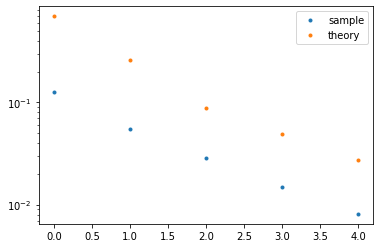

In [16]:
plt.plot(vars_u, ".", label="sample")
plt.plot(vars_u_theory, ".", label="theory")
plt.yscale("log")
plt.legend()

In [17]:
slfkjlsdkj

NameError: name 'slfkjlsdkj' is not defined

# estimate variance

In [ ]:
L = 10 # linear time estimator uses L2n samples --> memory L2n, computation Ln, Var(KSD_L) = 1/Ln Var(h(X, Y))
      # where n = nr of samples for U-estimator

In [ ]:
def sample_ksd(n, source, target, mode="l"):
    if mode=="u":
        samples = source.sample(n)
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    elif mode=="l":
        samples = source.sample(2*n).split(2)
        return stein.ksd_squared_l(*samples, target.logpdf, kernel, False)
    else:
        raise ValueError("mode must be 'u' or 'l'.")

# @partial(jit, static_argnums=range(5))
def sample_ksd_variance(n, m, source, target, mode="l"):
    return np.var(np.asarray([sample_ksd(n, source, target, mode) for _ in range(m)]))

In [ ]:
# test the variance variance
n = 1000
m = 2
variances = [sample_ksd_variance(n, m, source, target, "l") for _ in range(100)]

In [ ]:
onp.var(variances)

In [ ]:
m = 100
vars_u = []
vars_l = []
ngrid = 2**onp.arange(5, 15)

for n in ngrid:
    print(n)
    vars_u.append(sample_ksd_variance(n, m, source, target, "u"))
    vars_l.append(sample_ksd_variance(L*n, m, source, target, "l"))

In [ ]:
vars_u, vars_l = [np.asarray(x) for x in (vars_u, vars_l)] 

if not np.all(vars_l / vars_u < 1):
    print("Variance is too high!!")

In [ ]:
plt.plot(ngrid, vars_l / vars_u, ".")
plt.xscale("log")

In [ ]:
vars_l

In [ ]:
vars_u

In [ ]:
m = 1000000
samples = source.sample(m).split(2)
hvar = stein.h_var(*samples, target.logpdf, kernel)
hvar

plt.plot(ngrid, vars_u, label="V_U in practice")
# plt.hlines(hvar, xmin=0, xmax=ngrid[-1], label="V_U in theory", color="r")
# plt.yscale("log")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
m = 1000000
samples = source.sample(m).split(2)
hvar = stein.h_var(*samples, target.logpdf, kernel)
hvar

plt.plot(ngrid, ngrid * L * vars_l, label="V_L in practice")
plt.hlines(hvar, xmin=0, xmax=ngrid[-1], label="V_L in theory", color="r")
# plt.yscale("log")
plt.xscale("log")
plt.legend()

In [ ]:
plt.plot(ngrid, ngrid * vars_u, ".")
plt.xscale("log")